# Prácticas Naive Bayes y KNN

In [ ]:
# Importación de librerias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

##### 1. Tomando como base este tutorial, crea un modelo de clasificación usando KNN con los mismos datos sintéticos. Para la elección de los mejores hiperparámetros usa un sistema de validación cruzada.

Primero crearemos los datos y los visualizaremos para asegurarnos que están bien

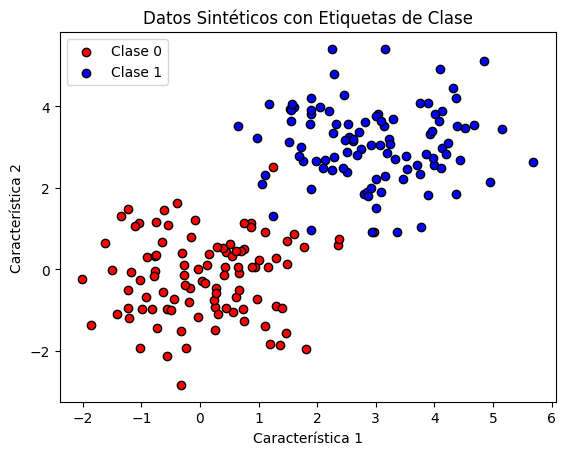

In [ ]:
SEMILLA = 41
np.random.seed(SEMILLA)

# Clase 0
class_0_data = np.random.normal(0, 1, size=(100, 2))
class_0_labels = np.zeros(100)

# Clase 1
class_1_data = np.random.normal(3, 1, size=(100, 2))
class_1_labels = np.ones(100)

COLORS = ('red', 'blue')

for i, data in enumerate((class_0_data, class_1_data)):
    plt.scatter(data[:, 0], data[:, 1], c=COLORS[i], edgecolor='k', label=f"Clase {i}")

plt.title('Datos Sintéticos con Etiquetas de Clase')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend()

plt.show()

Vemos que los gráficos se han cargardo correctamente.

Si vamos a realizar el modelo KNN, tenemos que seleccionar cuidadosamente que características vamos a utilizar. Para saber que características utilizar haremos un estudio de las correlaciones entre las características.

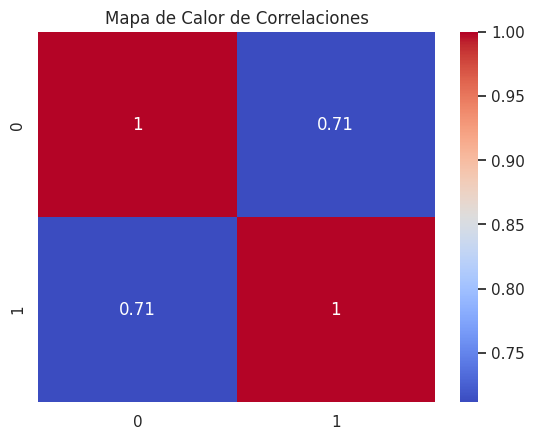

In [ ]:
sns.set()
sns.heatmap(pd.DataFrame(np.vstack((class_0_data, class_1_data))).corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlaciones')
plt.show()

Al ser obviamente dos características, estas están estrechamente relacionadas.
Crearemos los datos de entrenamiento y prueba.

In [ ]:
# Combinar datos de ambas clases
X = np.vstack((class_0_data, class_1_data))
y = np.concatenate((class_0_labels, class_1_labels))

# Dividir el conjunto de datos en entrenamiento y test
train, test = train_test_split(pd.DataFrame(np.hstack((X, y.reshape(-1, 1))),
                               columns=['Clase 0', 'Clase 1', 'Label']),
                               test_size=0.2, random_state=42)
train.reset_index(inplace = True)
test.reset_index(inplace = True)

Para escoger los mejores hiperpárametros para KNN tendremos que hacer una validación cruzada. Para ello habrá que usar `KFold`. Crearemos para ellos una función que reciba:
* el k máximo de vecinos
* las n divisiones de datos
* Dataframe de entrenamiento
* el nombre de la columna objetivo

In [ ]:
def cross_validation(neighbors, splits, train, target):
    """
    Realiza validación cruzada con K-Vecinos más Cercanos.

    Parámetros:
    - neighbors: int, número máximo de vecinos (k) a evaluar.
    - splits: int, número de divisiones (folds) en la validación cruzada.
    - train: DataFrame, conjunto de datos de entrenamiento.
    - target: str, nombre de la columna objetivo.

    Retorna:
    - None
    """
    cv = KFold(n_splits=splits, shuffle=True)

    for i, weights in enumerate(('uniform', 'distance')):
        total_scores = []

        for k in range(1, neighbors):
            fold_accuracy = []
            knn = KNeighborsClassifier(n_neighbors=k, weights=weights)

            for train_fold, test_fold in cv.split(train):
                # División aleatoria
                f_train, f_test = train.loc[train_fold], train.loc[test_fold]
                # Entrenamiento
                knn.fit(X = f_train.drop([target], axis=1), y = f_train[target])
                # Predicción
                y_pred = knn.predict(f_test.drop([target], axis=1))
                # Evaluación
                accuracy = accuracy_score(f_test[target], y_pred)
                fold_accuracy.append(accuracy)
            total_scores.append(np.mean(fold_accuracy))

        plt.plot(range(1,len(total_scores)+1), total_scores, marker='o', label=weights)
        print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (k=" + str(np.argmax(total_scores) + 1) + ")")
        plt.ylabel('Acc')

    plt.legend()
    plt.show()

Max Value uniform : 1.0 (k=1)
Max Value distance : 1.0 (k=1)


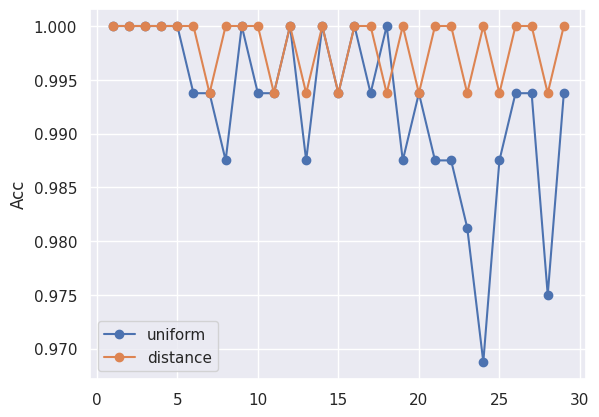

In [ ]:
MAX_NEIGHBORS = 30
N_SPLITS = 5

cross_validation(MAX_NEIGHBORS, N_SPLITS, train, 'Label')

Una vez que hemos identificado una buena parametrización, pasamos a la ejecución del modelo.

In [ ]:
K = 4
WEIGHTS = 'distance'

X_train = train[['Clase 0', 'Clase 1']]
X_test = test[['Clase 0', 'Clase 1']]
y_train = train['Label']
y_test = test['Label']

knn = KNeighborsClassifier(n_neighbors=K, weights=WEIGHTS)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc}')

Accuracy: 0.95


Vemos que el rendimiento del modelo es bueno, vamos a representar los valores con un mapa de fronteras de decisión y la matriz de confusión.

<Figure size 1400x600 with 0 Axes>

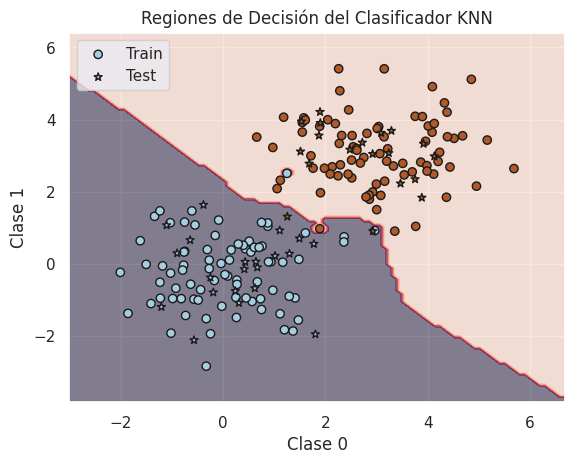

In [ ]:
plt.figure(figsize=(14, 6))

disp = DecisionBoundaryDisplay.from_estimator(
    knn,
    X_train,
    response_method="predict",  # Usar el método de predicción
    xlabel="Clase 0",
    ylabel="Clase 1",
    alpha=0.5  # Transparencia del fondo
)

# Graficar los puntos de entrenamiento y prueba
plt.scatter(X_train['Clase 0'], X_train['Clase 1'], c=y_train, edgecolor="k", label="Train", cmap=plt.cm.Paired)
plt.scatter(X_test['Clase 0'], X_test['Clase 1'], c=y_test, marker="*", edgecolor="k", label="Test", cmap=plt.cm.Paired)
plt.title("Regiones de Decisión del Clasificador KNN")
plt.legend()
plt.show()

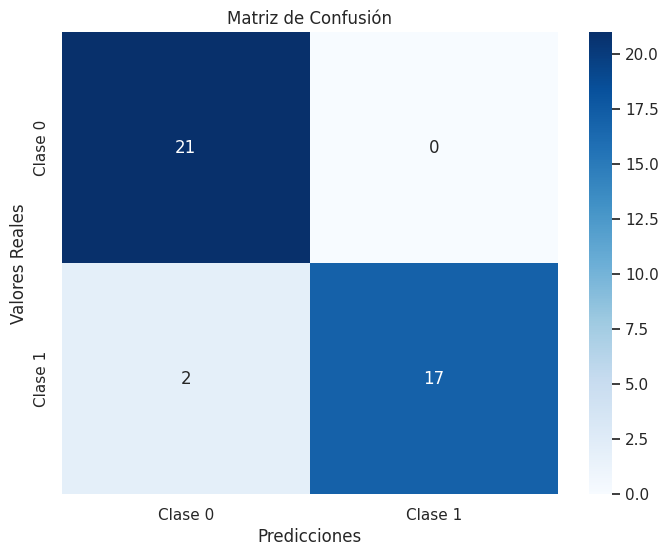

In [ ]:
cm = confusion_matrix(y_test, y_pred)

CLASSES = ('Clase 0', 'Clase 1')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

##### 2. Usando los datos almacenados en data2.csv, crea un modelo de clasificación usando los modelos de NaiveBayes mostrados en el quinto vídeo. Indicad qué modelo da mejores resultados. Os toca investigar cómo cargar un archivo csv desde Google Collab.

Subimos el archivo csv y guardamos los datos en un `dataframe` de `pandas`.

In [ ]:
df = pd.read_csv('/content/data2.csv')

df

,Feature_1,Feature_2,Label
0,0.496714,0.000000,0.0
1,0.647689,1.523030,0.0
2,0.000000,0.000000,0.0
3,1.579213,0.767435,0.0
4,0.000000,0.542560,0.0
...,...,...,...
995,3.800410,3.754291,1.0
996,4.188913,3.708304,1.0
997,3.351448,4.070150,1.0
998,2.973479,2.118125,1.0


Visualizamos los datos una vez han sido cargados.

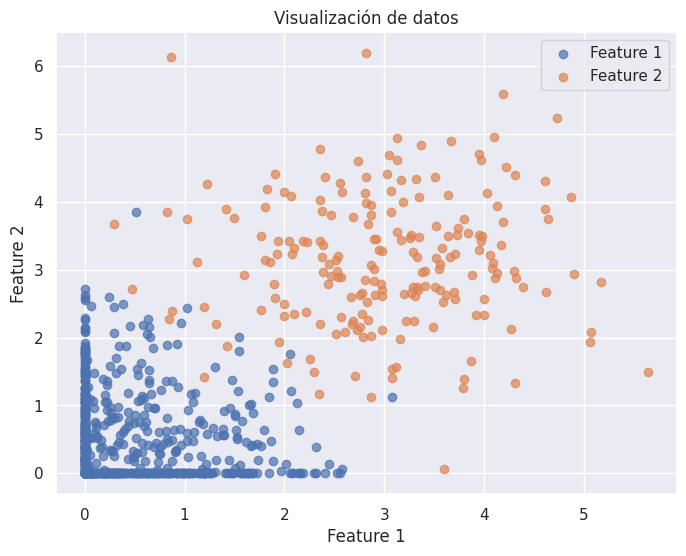

In [ ]:
plt.figure(figsize=(8, 6))
for index, label in enumerate(df['Label'].unique()):
    subset = df[df['Label'] == label]
    plt.scatter(subset['Feature_1'], subset['Feature_2'], label=f'Feature {index+1}', alpha=0.7)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualización de datos')
plt.legend()
plt.grid(True)

plt.show()

Ahora creamos los datos de entrenamiento y test. Hay que usar el método `T` para transponer la matriz porque pone las filas como columnas y por lo tanto es algo incorrecto.

In [ ]:
X = np.vstack((df['Feature_1'], df['Feature_2'])).T
y = df['Label']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

Ahora entrenaremos un modelo Naive Bayes. Existen diferentes tipos de modelos de Naive Bayes:

* GaussianNB: Distribución gausiana para datos numéricos.
* MultinomialNB: Distribución multinomial para recuentos, los datos son textos.
* ComplementNB: Extensión de la anterior, para clasificaciones no balanceadas. Es decir, una clase aparece con mayor frecuencia.
* BernouilliNB: Distribución Bernouilli para características binarias. Clasificación de textos cortos.
* CategoricalNB: Para datos categóricos. Utiliza distribución de Laplace.

Vamos a probar todos los modelos y ver que resultados proporcionan.

In [ ]:
model = GaussianNB()
model2 = MultinomialNB()
model3 = ComplementNB()
model4 = BernoulliNB()
model5 = CategoricalNB()

for MODEL in (model, model2, model3, model4, model5):
    MODEL.fit(X_train2, y_train2)
    y_pred = MODEL.predict(X_test2)


Y por último hacemos las pruebas pertinentes. Primero haremos la precisión de los modelos y luego visualizaremos los datos.

In [ ]:
y_pred1 = model.predict(X_test2)
y_pred2 = model2.predict(X_test2)
y_pred3 = model3.predict(X_test2)
y_pred4 = model4.predict(X_test2)
y_pred5 = model5.predict(X_test2)

PREDS = (y_pred1, y_pred2, y_pred3, y_pred4, y_pred5)

for i, y_pred in enumerate(PREDS):
    acc = accuracy_score(y_test2, y_pred)
    print(f'Accuracy of Model {i+1}: {acc}')

Accuracy of Model 1: 0.99
Accuracy of Model 2: 0.78
Accuracy of Model 3: 0.585
Accuracy of Model 4: 0.78
Accuracy of Model 5: 0.98


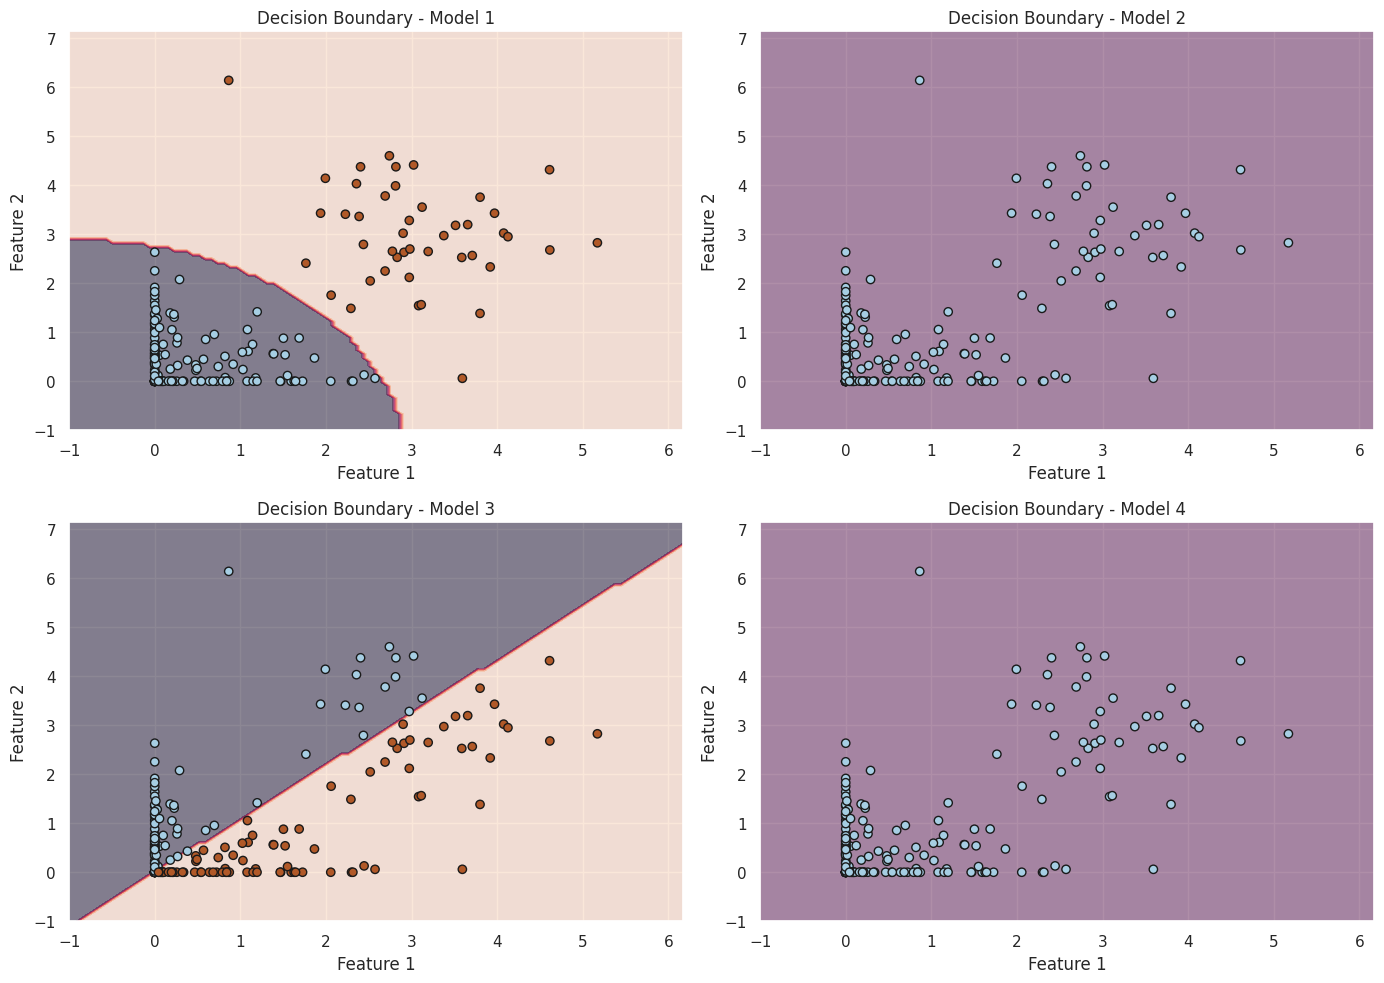

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 filas y 2 columnas

# Modelo 1
DecisionBoundaryDisplay.from_estimator(
    model,
    X_test2,
    response_method='predict',
    alpha=0.5,
    ax=axes[0, 0]  # Asignar subplot
)
axes[0, 0].scatter(X_test2[:, 0], X_test2[:, 1], c=y_pred1, edgecolors='k', cmap=plt.cm.Paired)
axes[0, 0].set_xlabel('Feature 1')
axes[0, 0].set_ylabel('Feature 2')
axes[0, 0].set_title('Decision Boundary - Model 1')
axes[0, 0].grid(True)

# Modelo 2
DecisionBoundaryDisplay.from_estimator(
    model2,
    X_test2,
    response_method='predict',
    alpha=0.5,
    ax=axes[0, 1]
)
axes[0, 1].scatter(X_test2[:, 0], X_test2[:, 1], c=y_pred2, edgecolors='k', cmap=plt.cm.Paired)
axes[0, 1].set_xlabel('Feature 1')
axes[0, 1].set_ylabel('Feature 2')
axes[0, 1].set_title('Decision Boundary - Model 2')
axes[0, 1].grid(True)

# Modelo 3
DecisionBoundaryDisplay.from_estimator(
    model3,
    X_test2,
    response_method='predict',
    alpha=0.5,
    ax=axes[1, 0]
)
axes[1, 0].scatter(X_test2[:, 0], X_test2[:, 1], c=y_pred3, edgecolors='k', cmap=plt.cm.Paired)
axes[1, 0].set_xlabel('Feature 1')
axes[1, 0].set_ylabel('Feature 2')
axes[1, 0].set_title('Decision Boundary - Model 3')
axes[1, 0].grid(True)

# Modelo 4
DecisionBoundaryDisplay.from_estimator(
    model4,
    X_test2,
    response_method='predict',
    alpha=0.5,
    ax=axes[1, 1]
)
axes[1, 1].scatter(X_test2[:, 0], X_test2[:, 1], c=y_pred4, edgecolors='k', cmap=plt.cm.Paired)
axes[1, 1].set_xlabel('Feature 1')
axes[1, 1].set_ylabel('Feature 2')
axes[1, 1].set_title('Decision Boundary - Model 4')
axes[1, 1].grid(True)

# Ajustar márgenes
plt.tight_layout()
plt.show()

Podemos ver claramente que la primera gráfica agrupa de manera acertada los datos, el resto de modelos fallan bastante (indicar que la gráfica del 5º modelo fallaba dando el error `Negative values in data passed to CategoricalNB (input X)`). También se pude realizar la matriz de confusión que aporta bastante información sobre el desempeño de cada modelo.

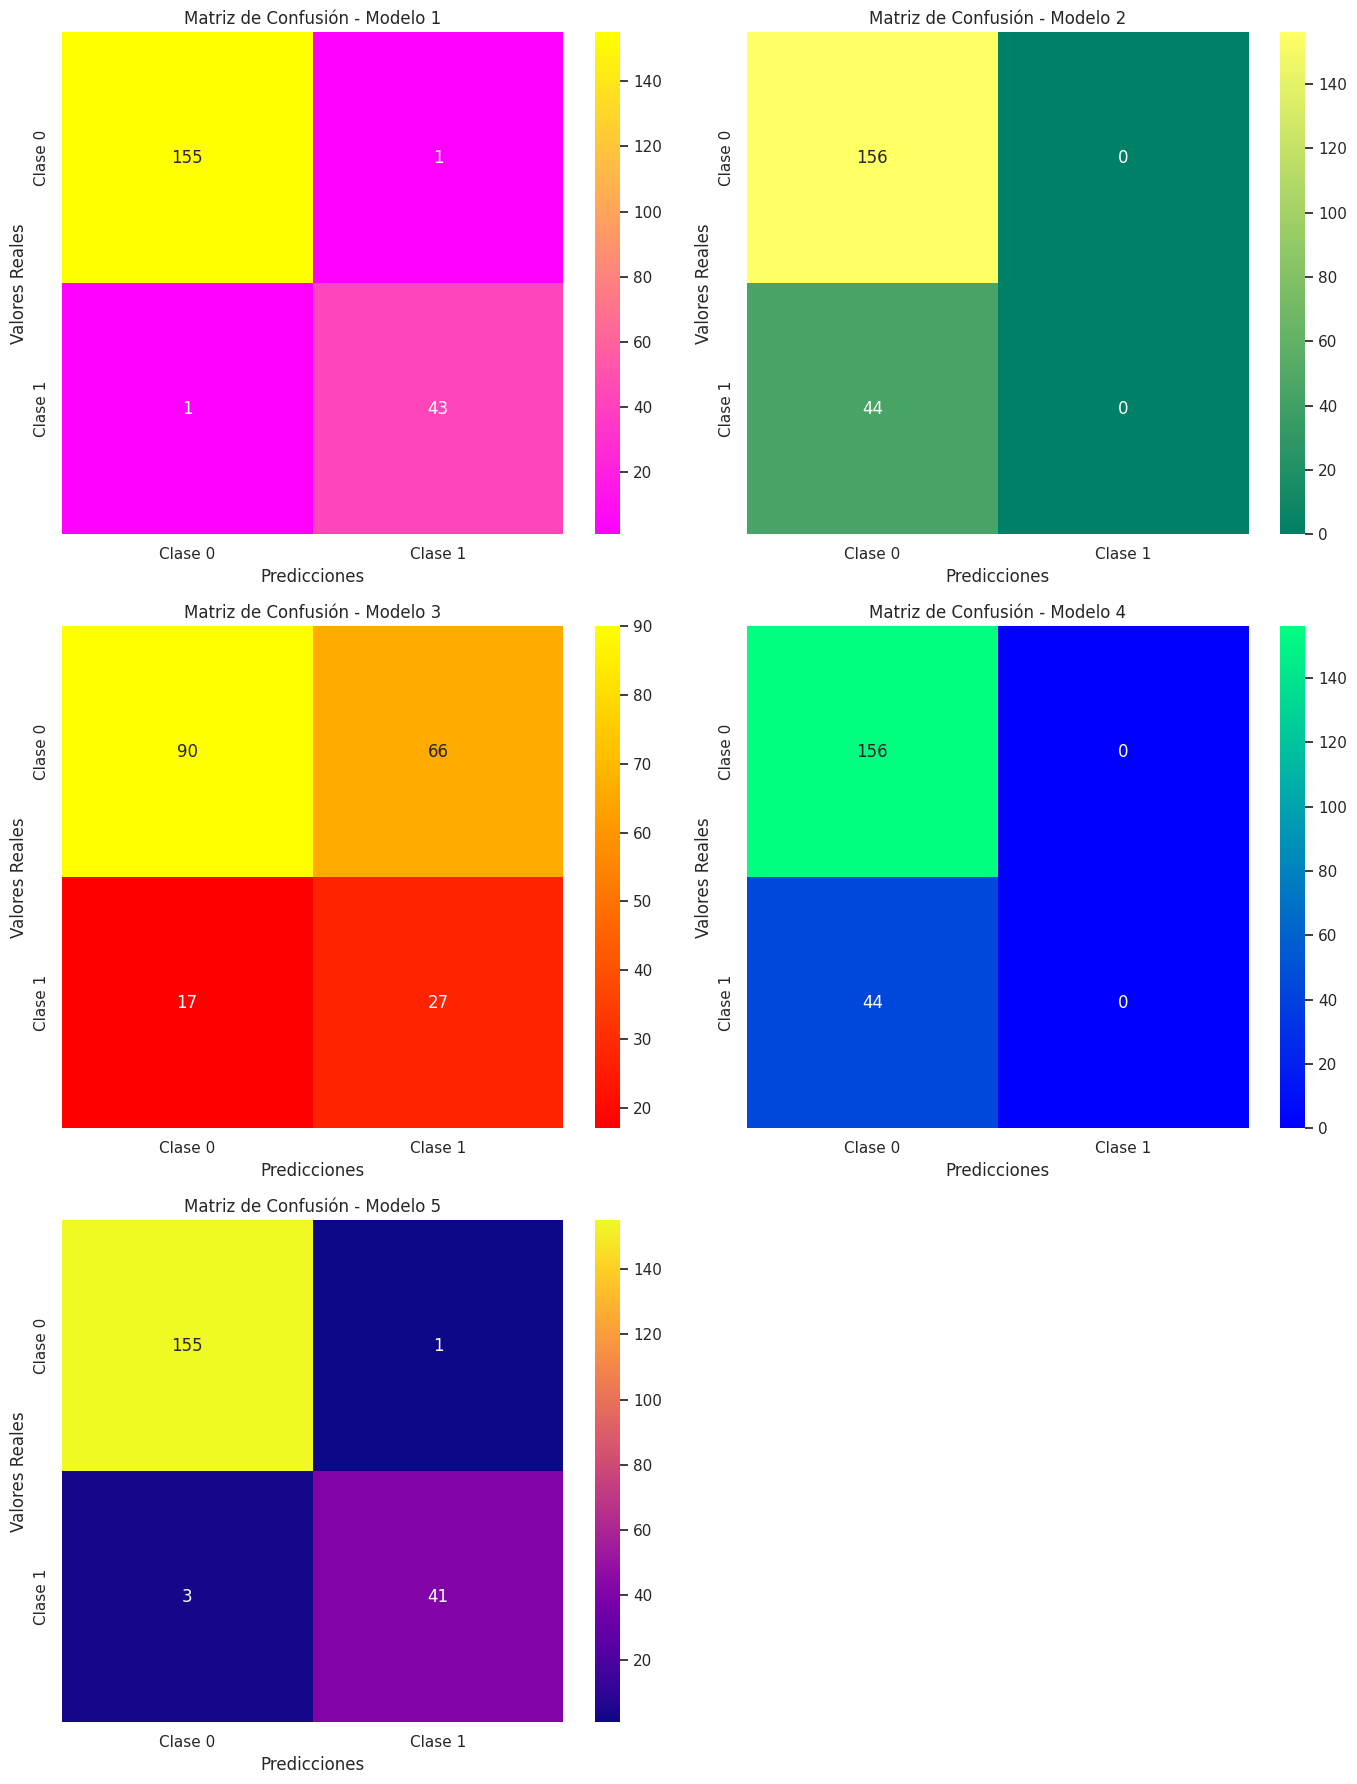

In [ ]:
cm1 = confusion_matrix(y_test2, y_pred1)
cm2 = confusion_matrix(y_test2, y_pred2)
cm3 = confusion_matrix(y_test2, y_pred3)
cm4 = confusion_matrix(y_test2, y_pred4)
cm5 = confusion_matrix(y_test2, y_pred5)

CLASSES = ('Clase 0', 'Clase 1')
CMS = (cm1, cm2, cm3, cm4, cm5)
CMAP = ('spring', 'summer', 'autumn', 'winter', 'plasma')

fig = plt.figure(figsize=(14, 18))

for i, cm in enumerate(CMS):
    plt.subplot(3, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap=CMAP[i], xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'Matriz de Confusión - Modelo {i+1}')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Reales')

plt.tight_layout()
plt.show()

De todos los modelos, el primero es el que mejor lo hace ya que obviamente al ser un dataset de valores numéricos es normal que el primero lo haga bien. El quinto también parece hacerlo bien como muestra la matriz de confusión. El resto de modelos fallan bastante y no son muy buenos.

##### 3. En este enlace puedes descargar un dataset que recoge diferentes características de vino rojo portugués "Vinho Verde" y la calidad del mismo. Crea un modelo de clasificación usando NaiveBayes (GaussianNB) y KNN.

Como siempre, importaremos los datos del CSV.

In [ ]:
df_wines = pd.read_csv('/content/winequality-red.csv')

df_wines

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Visualizamos los datos cargados. Es muy importante a la hora de trabajar con KNN que características están más relacionadas entre sí. Por lo que haremos un estudio de sus correlaciones para ver que características tienen una mayor correlación entre ellas.

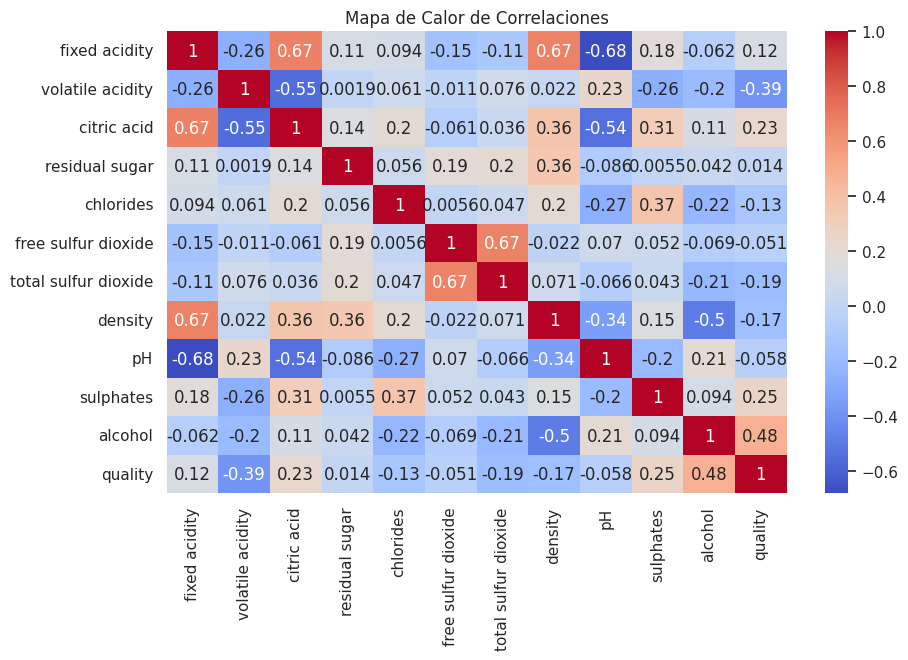

In [ ]:
plt.figure(figsize=(10, 6))
sns.set()
sns.heatmap(df_wines.corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlaciones')
plt.show()

En este mapa de calor se muestran las correlaciones de todas las variables del dataset. En donde las correlaciones más fuertes se marcan en tonos cálidos o fríos si es negativa. Ahora generaremos los datos de entrenamiento y prueba.

In [ ]:
X = df_wines.drop('quality', axis=1)
y = df_wines['quality']

X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(X, y, test_size=0.2, random_state=42)

train_wine, test_wine = train_test_split(df_wines, test_size=0.2, random_state=42)
train_wine.reset_index(inplace = True)
test_wine.reset_index(inplace = True)

Ahora crearemos los modelos de Naive Bayes y KNN para nuestros datos de entrenamientos. Para el KNN tenemos que hacer la validación cruzada para sacar el mejor número de vecinos para utilizar. Usaremos de nuevo 30 vecinos en 5 grupos de datos.

Max Value uniform : 0.5598100490196078 (k=1)
Max Value distance : 0.5957659313725491 (k=14)


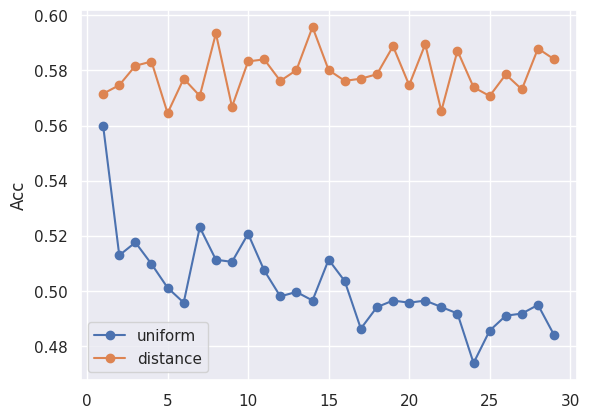

In [ ]:
cross_validation(MAX_NEIGHBORS, N_SPLITS, train_wine, 'quality')

Una vez tenemos los mejores hiperparámetros, creamos los modelos y los entrenamos.

In [ ]:
model_nb = GaussianNB()
model_nb.fit(X_train_wine, y_train_wine)

model_knn = KNeighborsClassifier(n_neighbors=14, weights='distance')
model_knn.fit(X_train_wine, y_train_wine)

KNeighborsClassifier(n_neighbors=14, weights='distance')

Y ahora comprobamos los resultados obtenidos gracias a estos modelos.

In [ ]:
y_pred_nb = model_nb.predict(X_test_wine)
y_pred_knn = model_knn.predict(X_test_wine)

print(f'Accuracy Naive Bayes: {accuracy_score(y_test_wine, y_pred_nb)}')
print(f'Accuracy KNN: {accuracy_score(y_test_wine, y_pred_knn)}')

Accuracy Naive Bayes: 0.55
Accuracy KNN: 0.571875


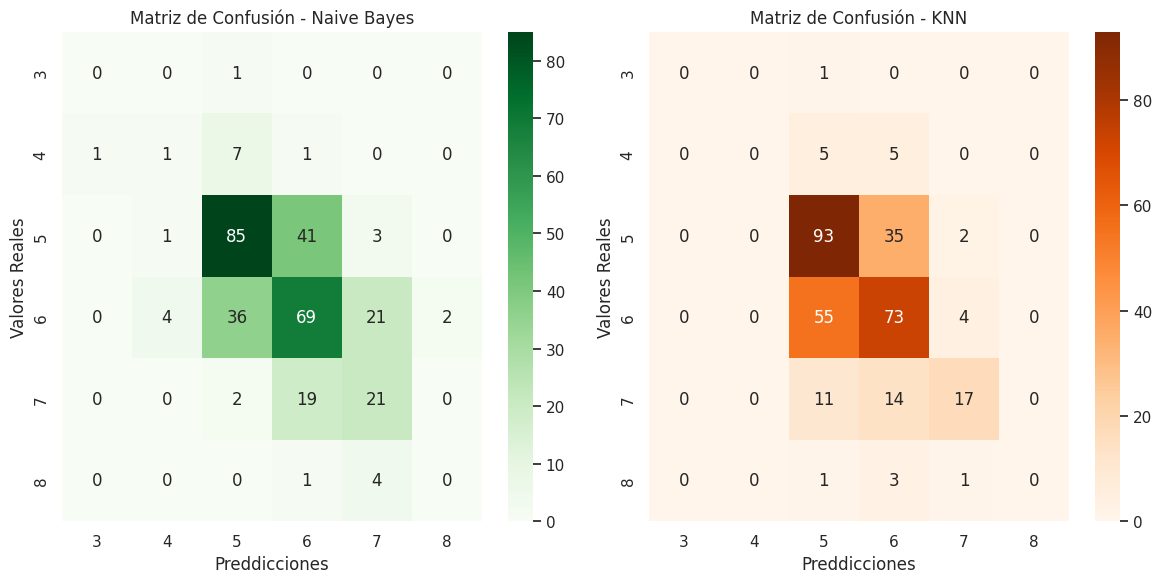

In [ ]:
cm_nb = confusion_matrix(y_test_wine, y_pred_nb)
cm_knn = confusion_matrix(y_test_wine, y_pred_knn)

DF_COLUMNS = sorted(df_wines['quality'].unique())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', xticklabels=DF_COLUMNS, yticklabels=DF_COLUMNS)
plt.xlabel('Preddicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión - Naive Bayes')

plt.subplot(1, 2, 2)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges', xticklabels=DF_COLUMNS, yticklabels=DF_COLUMNS)
plt.xlabel('Preddicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión - KNN')

plt.tight_layout()
plt.show()

Vemos que el rendimiento de ambos modelos no es demasido bueno. Aunque parece que el modelo KNN ha fallado menos que Naive Bayes, esto es gracias a la validación cruzada que nos ha indicado que k vecinos y peso eran los indicados para sacar los mejores resultados.

##### 4. Plantea el problema anterior con un modelo de regresión usando KNN. En el vídeo 7 hay un ejemplo de regresión con KNN.

Para realizar KNN para un modelo de regresión hay que utilizar `KNeighborsRegressor` que usa datos continuos y su resultado se calcula a partir de la media de los valores de sus vecinos más cercanos.

Para realizar la validación cruzada usaremos otra función en donde:
* Use `KNeighborsRegressor`
* Y cambie la **Precisión** (*Accuracy*) por el **Error Cuadrático Medio**.

In [ ]:
def cross_validation_regression(neighbors, splits, train, target):
    """
    Realiza validación cruzada con K-Vecinos más Cercanos.

    Parámetros:
    - neighbors: int, número máximo de vecinos (k) a evaluar.
    - splits: int, número de divisiones (folds) en la validación cruzada.
    - train: DataFrame, conjunto de datos de entrenamiento.
    - target: str, nombre de la columna objetivo.

    Retorna:
    - None
    """
    cv = KFold(n_splits=splits, shuffle=True)

    for i, weights in enumerate(('uniform', 'distance')):
        total_scores = []
        for k in range(1, neighbors):
            fold_errors = []
            knn = KNeighborsRegressor(n_neighbors=k, weights=weights)
            for train_fold, test_fold in cv.split(train):
                # División aleatoria
                f_train, f_test = train.loc[train_fold], train.loc[test_fold]
                # Entrenamiento
                knn.fit(X=f_train.drop([target], axis=1), y=f_train[target])
                # Predicción
                y_pred = knn.predict(f_test.drop([target], axis=1))
                # Evaluación
                mse = mean_squared_error(f_test[target], y_pred)
                fold_errors.append(mse)
            total_scores.append(np.mean(fold_errors))

        # Convertimos errores a métricas de desempeño (ej. negativo de MSE para visualización ascendente)
        plt.plot(range(1, len(total_scores) + 1), total_scores, marker='o', label=weights)
        print('Min Value (' + weights + '): ' + str(min(total_scores)) + " (k=" + str(np.argmin(total_scores) + 1) + ")")

        plt.ylabel('MSE')

    plt.legend()
    plt.show()

Min Value (uniform): 0.5905480713721438 (k=22)
Min Value (distance): 0.5413685612425632 (k=13)


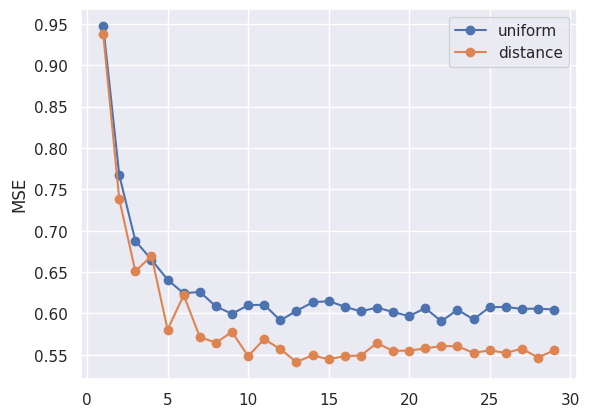

In [ ]:
cross_validation_regression(MAX_NEIGHBORS, N_SPLITS, train_wine, 'quality')

En este caso (como es mejor que MSE sea mínimo), parece que los pesos por distancia dan mejores resultados que teniendo en cuenta el peso uniforme. Por lo que creamos nuestro modelo de regresión con 22 vecinos y peso por distancia.

In [ ]:
model_knn_reg = KNeighborsRegressor(n_neighbors=13, weights='distance')
model_knn_reg.fit(X_train_wine, y_train_wine)

KNeighborsRegressor(n_neighbors=13, weights='distance')

Y ahora hacemos la predicción y graficamos los resultados. De nuevo, hay que redondear los datos.

In [ ]:
y_pred_knn_reg = model_knn_reg.predict(X_test_wine)

print(f'Error Cuadrático Medio: {mean_squared_error(y_test_wine, y_pred_knn_reg)}')

Error Cuadrático Medio: 0.4461144960486562


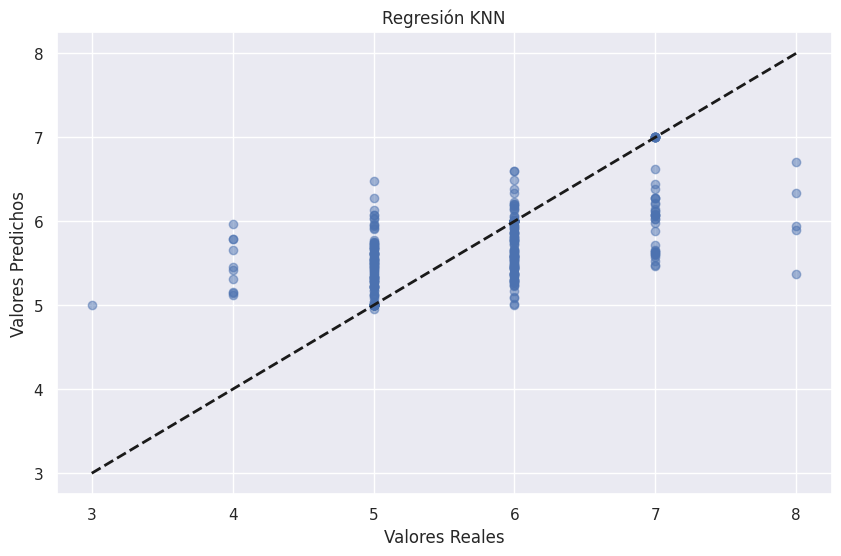

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_wine, y_pred_knn_reg, alpha=0.5)
plt.plot([y_test_wine.min(), y_test_wine.max()], [y_test_wine.min(), y_test_wine.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Regresión KNN')
plt.show()

Vemos que nuestro modelo no realiza bien las predicciones ya que los puntos están demasiado alejados de la línea, por lo que habría que trabajar algunos aspectos como la estandarización y outliers que estén afectando el modelo.

Sin embargo, necesitamos comparar los resultados con los del KNN de clasificación. La única forma de comparar ambos modelos es haciendo los que se conoce un **informe de clasificación**.

---

#### Informe de clasificación

##### 1. Introducción

En este informe se pretende comparar los desempeños de ambos modelos KNN tanto el de clasificación como el de regresión para predecir la calidad del vino. Esto nos ayudará a comprobar que las predicciones continuas, transformadas en categorías, son eqivalentes o inferiores a las del modelo de clasificación.

##### 2. Análisis Exploratorio de Datos (EDA)

El análisis exploratorio de datos mostró correlaciones significativas entre las características y la calidad del vino. Por ejemplo, "alcohol" tiene una correlación positiva moderada con la calidad (0.48), mientras que "volatile acidity" tiene una correlación negativa (-0.39). Estas relaciones se utilizaron para seleccionar las características más relevantes en la construcción de los modelos.

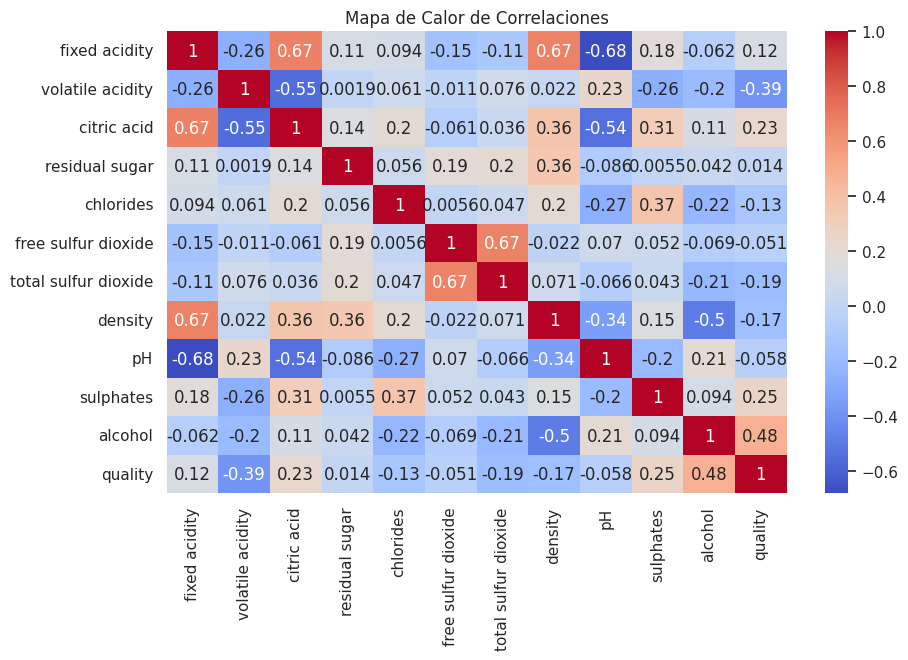

In [ ]:
plt.figure(figsize=(10, 6))
sns.set()
sns.heatmap(df_wines.corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlaciones')
plt.show()

##### 3. Presentación de Modelos

* El modelo KNN de **clasificación** se diseñó para predecir directamente la calidad como una categoría discreta (valores entre 3 y 8). Se usó las $k$
instancias más cercana que mejor resultado ofreció en la validación cruzada.

```python
KNeighborsClassifier(n_neighbors=14, weights='distance')
```


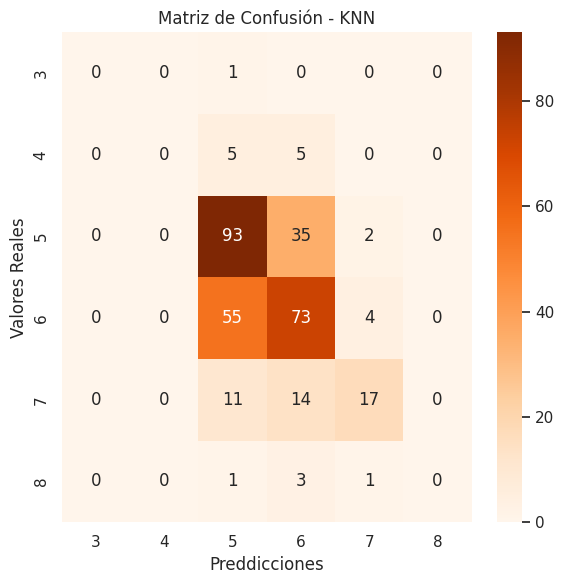

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges', xticklabels=DF_COLUMNS, yticklabels=DF_COLUMNS)
plt.xlabel('Preddicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión - KNN')

plt.tight_layout()
plt.show()

* El modelo KNN de **regresión** predice un valor continuo para la calidad del vino. Para comparar este modelo con el KNN de clasificación, las predicciones continuas se redondearon al entero más cercano, permitiendo una transformación en clases discretas.

```python
KNeighborsRegressor(n_neighbors=13, weights='distance')
```

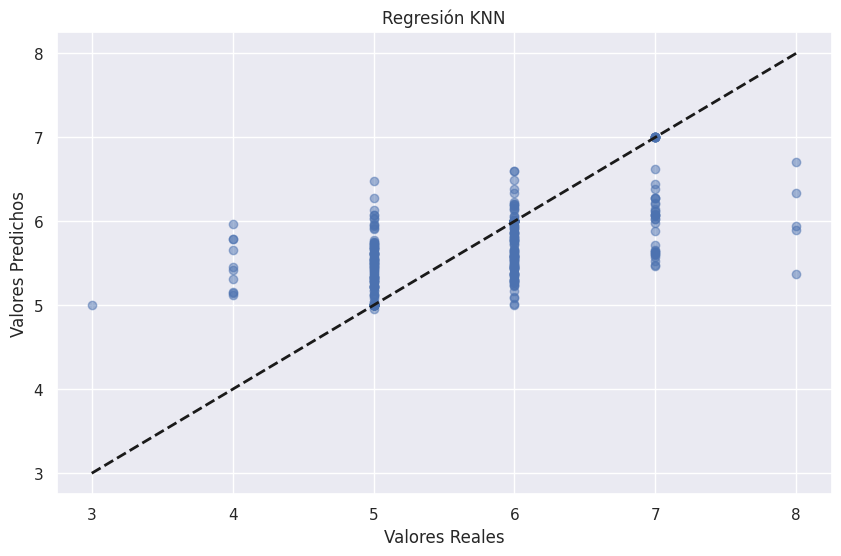

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_wine, y_pred_knn_reg, alpha=0.5)
plt.plot([y_test_wine.min(), y_test_wine.max()], [y_test_wine.min(), y_test_wine.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Regresión KNN')
plt.show()

#### 4. Comparación de resultados



In [ ]:
print(f'Accuracy KNN Clasificación: {accuracy_score(y_test_wine, y_pred_knn)*100}%')
print(f'Accuracy KNN Regresión: {accuracy_score(y_test_wine, np.round(y_pred_knn_reg))*100}%')

Accuracy KNN Clasificación: 57.1875%
Accuracy KNN Regresión: 57.1875%


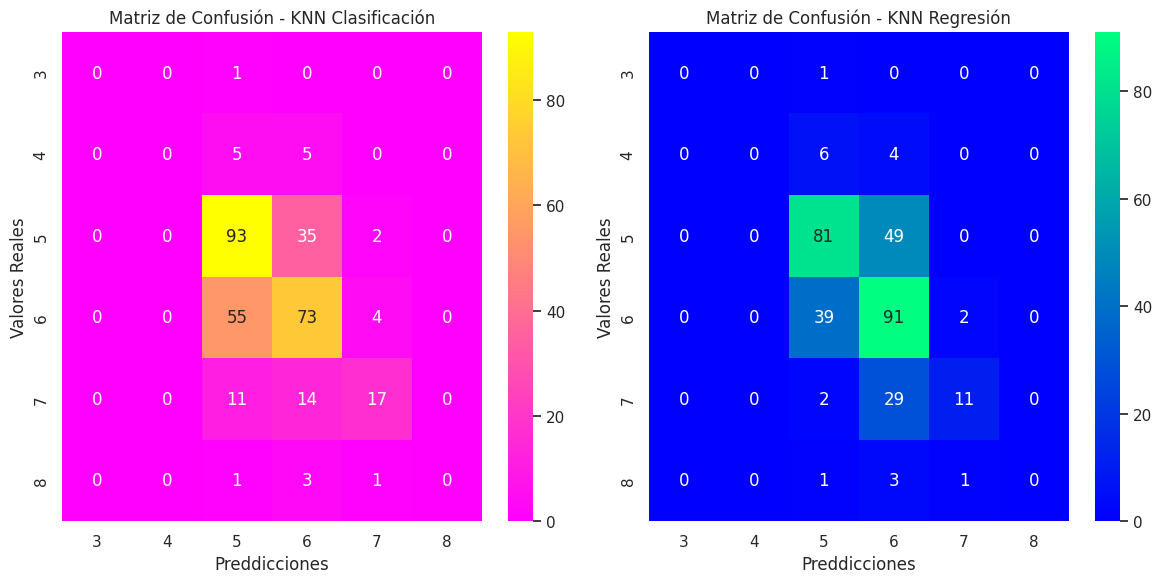

In [ ]:
cm_knn_cls = confusion_matrix(y_test_wine, y_pred_knn)
cm_knn_reg = confusion_matrix(y_test_wine, np.round(y_pred_knn_reg))

DF_COLUMNS = sorted(df_wines['quality'].unique())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_knn_cls, annot=True, fmt='d', cmap='spring', xticklabels=DF_COLUMNS, yticklabels=DF_COLUMNS)
plt.xlabel('Preddicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión - KNN Clasificación')

plt.subplot(1, 2, 2)
sns.heatmap(cm_knn_reg, annot=True, fmt='d', cmap='winter', xticklabels=DF_COLUMNS, yticklabels=DF_COLUMNS)
plt.xlabel('Preddicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión - KNN Regresión')

plt.tight_layout()
plt.show()

En los resultados podemos comprobar que por muy poco el modelo de regresión tiene mejores resultados que el de clasificación que tuvo más errores en las calidades superiores.

##### 5. Conclusión

En este análisis, el modelo KNN de regresión demostró un mejor desempeño para predecir la calidad del vino en comparación con el modelo KNN de clasificación. Sin embargo, el modelo de clasificación podría ser útil en casos donde sea importante predecir un valor discreto que no necesariamente caiga en los valores continuos.

---

##### 5. Usando los datos almacenados en data5.csv, crea un modelo de clasificación usando NaiveBayes y KNN. Haz un estudio inicial de las correlaciones entre las variables.

Para hacer un estudio inicial de las correlaciones podemos volver a realizar el mapa de calor que hicimos antes con los vinos.

In [ ]:
df_5 = pd.read_csv('/content/data5.csv')

df_5

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-2.250270,-1.646135,1.436570,1.148096,-0.223791,2.0
1,-1.785269,-0.565972,1.346475,1.041822,-0.697704,2.0
2,1.589542,0.796631,-1.328454,-1.005298,1.753727,1.0
3,1.832943,-0.284234,-1.907732,-1.272604,-0.718502,0.0
4,1.012438,0.080761,-0.998305,-0.524684,-1.071300,0.0
...,...,...,...,...,...,...
995,0.334226,-0.021846,-0.427070,-0.198279,-0.423734,2.0
996,1.645415,0.398429,-1.485906,-1.221208,-0.561532,0.0
997,-1.597413,-1.878053,0.784759,0.485133,-0.636929,2.0
998,-0.010668,0.220133,0.078729,0.221473,-1.431986,1.0


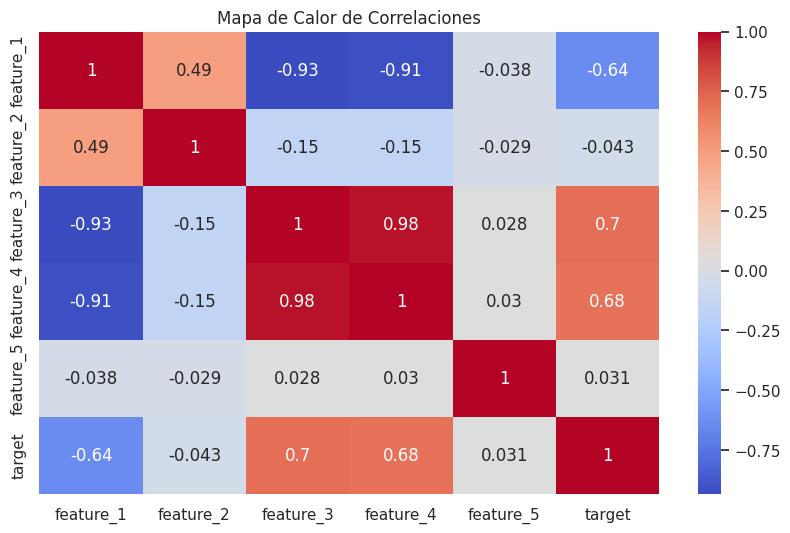

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_5.corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlaciones')
plt.show()

Podemos observar que las características feature_3 y feature_4 tienen una alta correlación, y estas dos tienen una alta correlación negativa con feature_1. También estas tienen una alta correlación con target.

Por lo que podemos decir que estas dos características parecen bastante influyentes en el set de datos.

In [ ]:
X = df_5.drop('target', axis=1)
y = df_5['target']

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=0.2, random_state=42)

train_df5, test_df5 = train_test_split(df_5, test_size=0.2, random_state=42)
train_df5.reset_index(inplace = True)
test_df5.reset_index(inplace = True)

Procedemos a crear los modelos de Naive Bayes y KNN.

Max Value uniform : 0.5512499999999999 (k=1)
Max Value distance : 0.55625 (k=1)


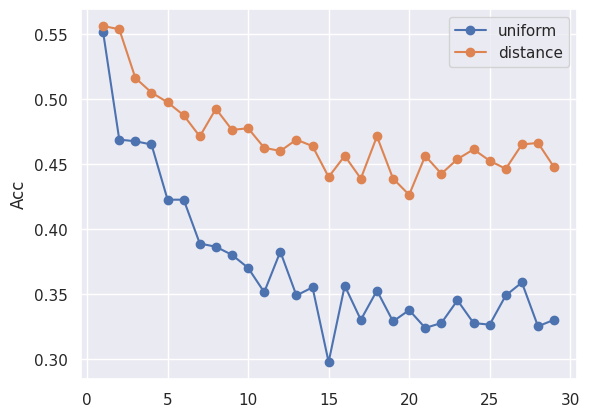

In [ ]:
cross_validation(MAX_NEIGHBORS, N_SPLITS, train_df5, 'target')

In [ ]:
model_nb_5 = GaussianNB()
model_nb_5.fit(X_train5, y_train5)

model_knn_5 = KNeighborsClassifier(n_neighbors=1, weights='distance')
model_knn_5.fit(X_train5, y_train5)

KNeighborsClassifier(n_neighbors=1, weights='distance')

Y por último, vemos como es el rendimiento de estos modelos.

In [ ]:
y_pred_nb_5 = model_nb_5.predict(X_test5)
y_pred_knn_5 = model_knn_5.predict(X_test5)

print(f'Accuracy Naive Bayes: {accuracy_score(y_test5, y_pred_nb_5)}')
print(f'Accuracy KNN: {accuracy_score(y_test5, y_pred_knn_5)}')

Accuracy Naive Bayes: 0.815
Accuracy KNN: 0.8


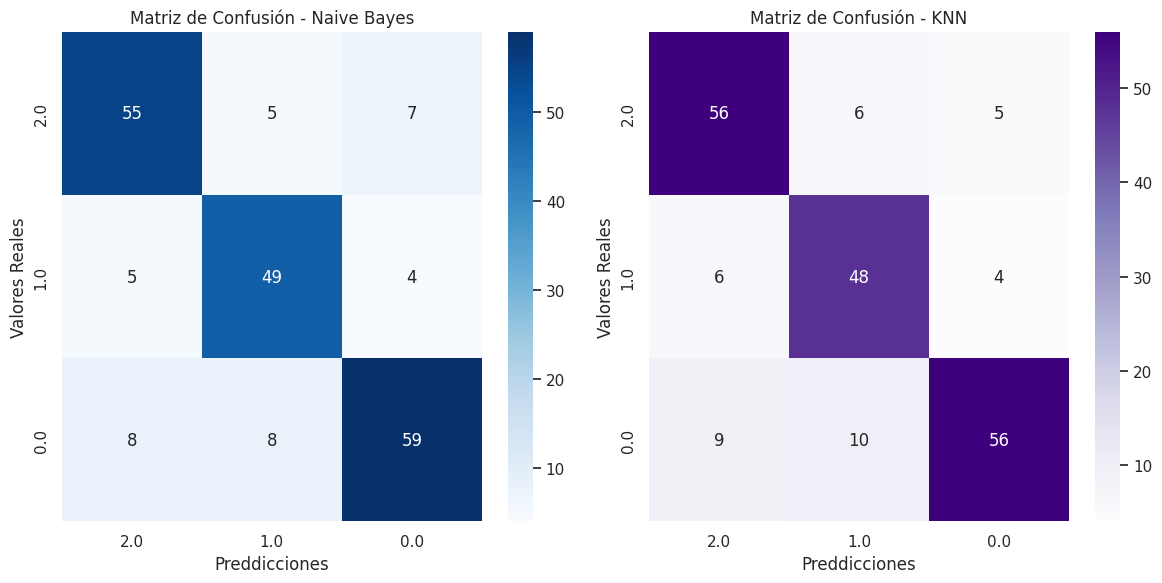

In [ ]:
cm_nb_5 = confusion_matrix(y_test5, y_pred_nb_5)
cm_knn_5 = confusion_matrix(y_test5, y_pred_knn_5)

DF_COLUMNS = df_5['target'].unique()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_nb_5, annot=True, fmt='d', cmap='Blues', xticklabels=DF_COLUMNS, yticklabels=DF_COLUMNS)
plt.xlabel('Preddicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión - Naive Bayes')

plt.subplot(1, 2, 2)
sns.heatmap(cm_knn_5, annot=True, fmt='d', cmap='Purples', xticklabels=DF_COLUMNS, yticklabels=DF_COLUMNS)
plt.xlabel('Preddicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión - KNN')

plt.tight_layout()
plt.show()

Podemos observar en las matrices de confusión que ambos modelos no lo han hecho mal, pero presentan algunos errores. De los dos el que menos ha fallado es el de Naive Bayes.